In [1]:
import pprint
import rasterio
from rasterio import features
import rasterio.warp
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR

In [2]:
# Base values
channel_descriptions = ['M11', 'I2', 'I1', 'NDVI_last', 'EVI2_last', 'total precipitation', 'wind speed', 'wind direction', 'minimum temperature', 'maximum temperature', 'energy release component', 'specific humidity', 'slope', 'aspect', 'elevation', 'pdsi', 'LC_Type1', 'total_precipitation_surface_last', 'forecast wind speed', 'forecast wind direction', 'forecast temperature', 'forecast specific humidity', 'active fire']

min_values = [np.float32(-100.0),
  np.float32(-100.0),
  np.float32(-100.0),
  np.float32(-9863.268),
  np.float32(-4422.217),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(-84.0),
  np.float32(-6.72),
  np.float32(1.0),
  np.float32(0.0),
  np.float32(0.0),
  np.float32(-89.999214),
  np.float32(-13.984883),
  np.float32(0.0),
  np.float32(0.0)]

max_values = [np.float32(15976.0),
  np.float32(15799.0),
  np.float32(15744.0),
  np.float32(9975.073),
  np.float32(9856.787),
  np.float32(122.0),
  np.float32(16.2),
  np.float32(360.0),
  np.float32(311.8),
  np.float32(325.4),
  np.float32(122.0),
  np.float32(0.01888),
  np.float32(63.85685),
  np.float32(359.42383),
  np.float32(4268.336),
  np.float32(8.28),
  np.float32(17.0),
  np.float32(204.1875),
  np.float32(14.295916),
  np.float32(89.98897),
  np.float32(39.505894),
  np.float32(0.0122514665),
  np.float32(2218.0)]


In [3]:
fire_folders = []
look_back = 5   # 5 days sequence
all_frames = []
data_limit, loop_counter, loop_start = 7, 0, 0
channel_descriptions = None
base_path = "./data"

target_shape_h, target_shape_w = 128, 128

print('Loading...')

for fire_folder in os.listdir(base_path):
    loop_counter += 1
    if loop_counter - loop_start > data_limit:
        break
    if loop_counter < loop_start:
        continue
    print('Progress: {0}/{1} ({2})'.format(loop_counter - loop_start, data_limit, loop_counter))
    fire_folders.append(fire_folder)
    for image_name in os.listdir(base_path + f"/{fire_folder}"):
        file_path = base_path + f"/{fire_folder}/{image_name}"
        
        with rasterio.open(file_path, 'r') as geotiff:
            src = geotiff.read()
            channel_descriptions = geotiff.descriptions
            zoom_factor = (1, target_shape_h / src.shape[1], target_shape_w / src.shape[2])
            resized_src = zoom(src, zoom_factor, order=1)
            resized_src = np.nan_to_num(resized_src, copy=True)
            all_frames.append(resized_src)

print(f'Loading done! Count = {len(all_frames)} | Shape = {all_frames[0].shape}')

data_frames = np.stack(all_frames)
print(data_frames.shape)

Loading...
Progress: 1/7 (1)
Progress: 2/7 (2)
Progress: 3/7 (3)
Progress: 4/7 (4)
Progress: 5/7 (5)
Progress: 6/7 (6)
Progress: 7/7 (7)
Loading done! Count = 168 | Shape = (23, 128, 128)
(168, 23, 128, 128)


In [4]:
from sklearn.preprocessing import MinMaxScaler, minmax_scale

#data_frames = (data_frames - min_bound) / (max_bound - min_bound)

for c in range(23):
    data_frames[:, c, :, :] = (data_frames[:, c, :, :] - min_values[c]) / (max_values[c] - min_values[c])

In [5]:
np.min(data_frames), np.max(data_frames)

(np.float32(0.0), np.float32(1.0))

In [6]:
X = []
Y = []

for t in range(0, data_frames.shape[0] - look_back):
    x_seq = data_frames[t:t+look_back]               # shape: (5, 23, H, W)
    y_mask = data_frames[t + look_back, 22]           # fire mask from channel 22

    X.append(x_seq)
    Y.append(y_mask)     # binarize

X = np.stack(X)  # shape: (273, 5, 23, 128, 128)
Y = np.expand_dims(np.stack(Y), axis=1)  # shape: (273, 1, 128, 128)

print(X.shape)
print(Y.shape)

(163, 5, 23, 128, 128)
(163, 1, 128, 128)


In [7]:
split_index = int(X.shape[0] * 0.8)

X_train = X[:split_index]
X_val = X[split_index:]

Y_train = Y[:split_index]
Y_val = Y[split_index:]

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

((130, 5, 23, 128, 128),
 (130, 1, 128, 128),
 (33, 5, 23, 128, 128),
 (33, 1, 128, 128))

In [8]:
X_train = torch.tensor(X_train).float()
Y_train = torch.tensor(Y_train).float()

X_val = torch.tensor(X_val).float()
Y_val = torch.tensor(Y_val).float()

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape

(torch.Size([130, 5, 23, 128, 128]),
 torch.Size([130, 1, 128, 128]),
 torch.Size([33, 5, 23, 128, 128]),
 torch.Size([33, 1, 128, 128]))

In [9]:
class WildfireDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

train_dataset = WildfireDataset(X_train, Y_train)
val_dataset = WildfireDataset(X_val, Y_val)

len(train_dataset), len(val_dataset)

(130, 33)

In [10]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='cuda')

In [12]:
import convlstm

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        orig_size = (330, 257)

        self.clstm = convlstm.ConvLSTM(
            input_size=(128, 128),
            input_dim=23,
            hidden_dim=[64],
            kernel_size=(3, 3),
            num_layers=1
        )
        # (8, 64, 128, 128)
        
        self.head = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        # (8, 1, 128, 128)

    def forward(self, x):
        batch_size = x.size(0)
        outputs, last_states = self.clstm(x)

        x = outputs[0][:, -1, :, :, :]
        x = self.head(x)
        return x

model = Net().to(device)

In [13]:

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        self.bce = nn.BCELoss()

    def forward(self, y_pred, y_true):
        bce_loss = self.bce(y_pred, y_true)
        # (8, 1, 128, 128)

        y_pred_flat = y_pred.view(y_pred.size(0), -1) # (8, 16384)
        y_true_flat = y_true.view(y_true.size(0), -1) # (8, 16384)

        intersection = (y_pred_flat * y_true_flat).sum(dim=1)
        union = y_pred_flat.sum(dim=1) + y_true_flat.sum(dim=1)

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score.mean()
        
        return dice_loss

class BCEWeightedLoss(nn.Module):
    def __init__(self, eps=1e-7):
        super(BCEWeightedLoss, self).__init__()
        self.eps = eps  # to avoid log(0)
        self.pos_weight = 10.0
        self.neg_weight = 1.0

    def forward(self, y_pred, y_true):
        """
        y_pred: probabilities after sigmoid, shape (B, 1, H, W)
        y_true: binary targets, shape (B, 1, H, W)
        """
        # Clamp predictions to avoid log(0)
        y_pred = torch.clamp(y_pred, self.eps, 1.0 - self.eps)

        # BCE loss calculation
        loss = - (self.pos_weight * y_true * torch.log(y_pred) + self.neg_weight * (1 - y_true) * torch.log(1 - y_pred))

        return loss.mean()  # return scalar loss


In [14]:

lr = 0.001 # 0.0001
num_epochs = 100

loss_fn = BCEWeightedLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
print_batch_every = 4

def train(epoch):
    model.train(True)
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % print_batch_every == (print_batch_every - 1):
            avg_loss_across_batches = running_loss / print_batch_every
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index + 1, avg_loss_across_batches))
            running_loss = 0.0
    
    print()

def validate():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(val_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(val_loader)
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('**********************************************************')
    print()


for epoch in range(num_epochs):
    train(epoch)
    validate()


Epoch: 1


C:\Users\neelr\AppData\Local\Temp\ipykernel_28000\2273281205.py:19: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  running_loss += loss.item()


Batch 4, Loss: 0.505
Batch 8, Loss: 0.061
Batch 12, Loss: 0.056
Batch 16, Loss: 0.019

Val Loss: 0.009
**********************************************************

Epoch: 2
Batch 4, Loss: 0.017
Batch 8, Loss: 0.033
Batch 12, Loss: 0.070
Batch 16, Loss: 0.020

Val Loss: 0.008
**********************************************************

Epoch: 3
Batch 4, Loss: 0.017
Batch 8, Loss: 0.030
Batch 12, Loss: 0.062
Batch 16, Loss: 0.019

Val Loss: 0.010
**********************************************************

Epoch: 4
Batch 4, Loss: 0.017
Batch 8, Loss: 0.028
Batch 12, Loss: 0.056
Batch 16, Loss: 0.020

Val Loss: 0.011
**********************************************************

Epoch: 5
Batch 4, Loss: 0.017
Batch 8, Loss: 0.028
Batch 12, Loss: 0.055
Batch 16, Loss: 0.019

Val Loss: 0.010
**********************************************************

Epoch: 6
Batch 4, Loss: 0.017
Batch 8, Loss: 0.028
Batch 12, Loss: 0.056
Batch 16, Loss: 0.019

Val Loss: 0.010
*************************************

In [15]:
for batch_index, batch in enumerate(train_loader):
    if batch_index == 4:
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        y_pred = model(x_batch)
        print("found")
        break

found


In [16]:
torch.max(y_batch), torch.max(y_pred), torch.min(y_batch), torch.min(y_pred)

(tensor(0.9261, device='cuda:0'),
 tensor(0.8617, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0., device='cuda:0'),
 tensor(6.9562e-05, device='cuda:0', grad_fn=<MinBackward1>))

In [17]:
y_batch_np = y_batch.cpu().detach().numpy()
y_pred_np = y_pred.cpu().detach().numpy()

y_pred_avg = (np.min(y_pred_np) + np.max(y_pred_np)) / 2.0
#y_pred_np = (y_pred_np - 0.0) / (0.65 - 0.0)

y_batch_np.shape, y_pred_np.shape

((8, 1, 128, 128), (8, 1, 128, 128))

In [18]:
np.max(y_pred_np), np.min(y_pred_np), y_pred_avg

(np.float32(0.8616652), np.float32(6.956183e-05), np.float32(0.43086737))

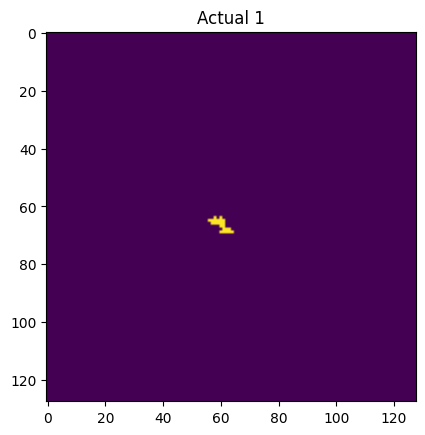

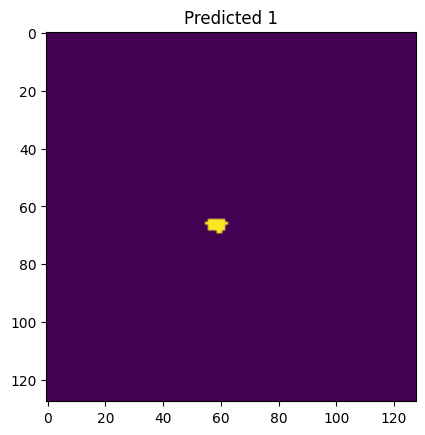

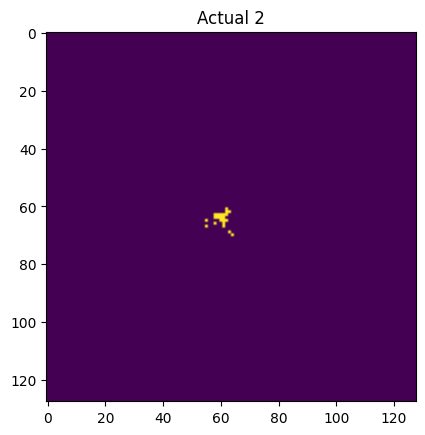

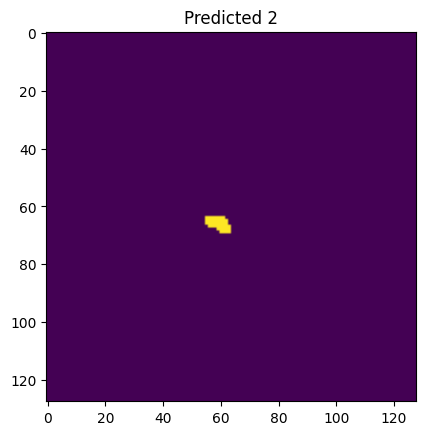

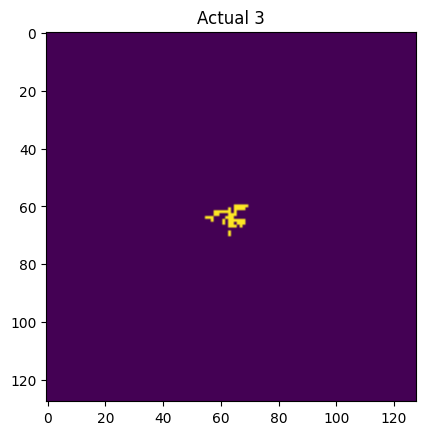

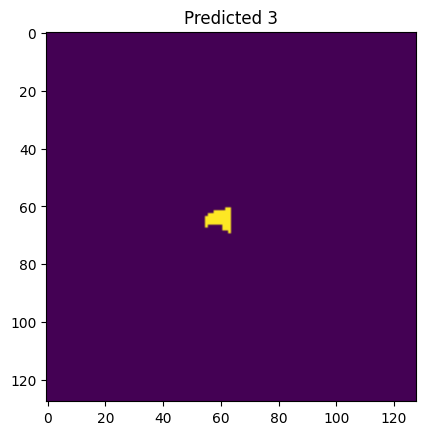

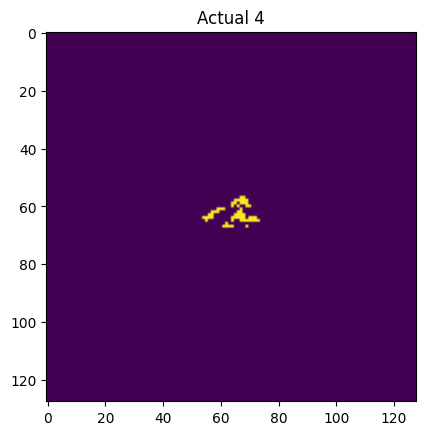

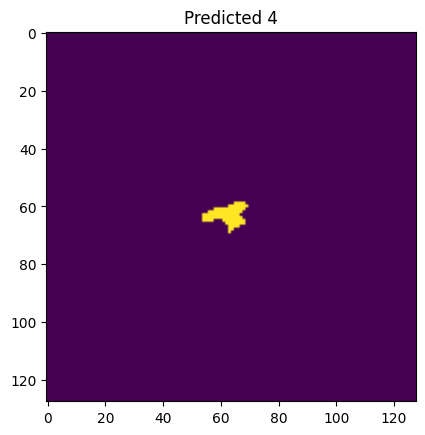

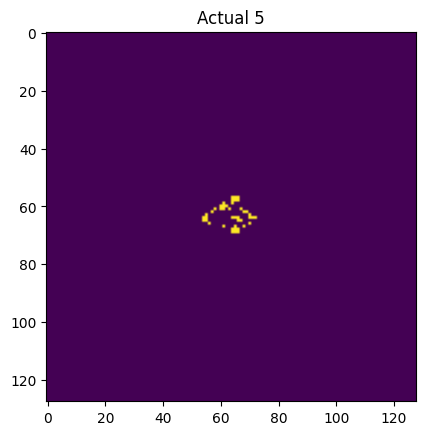

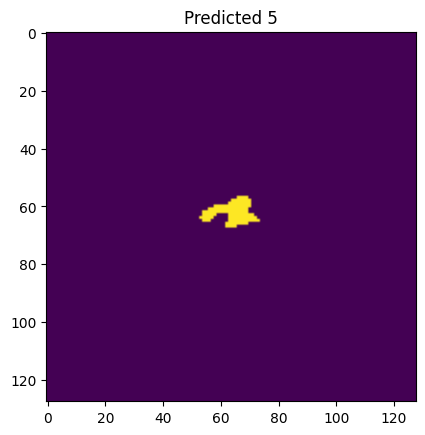

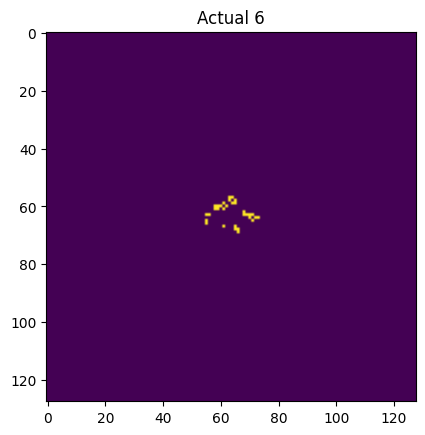

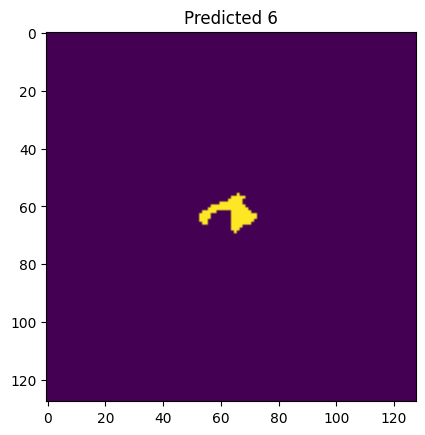

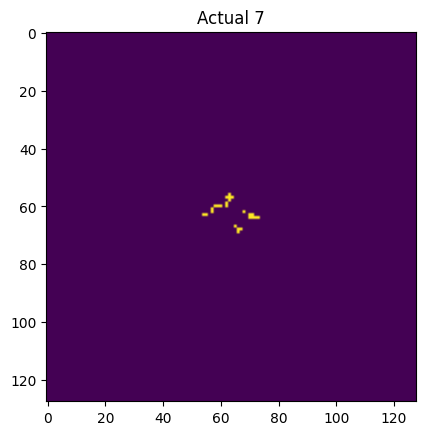

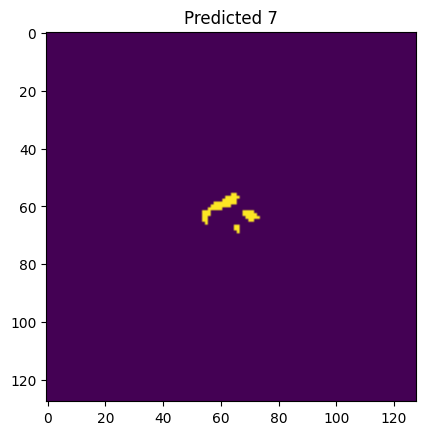

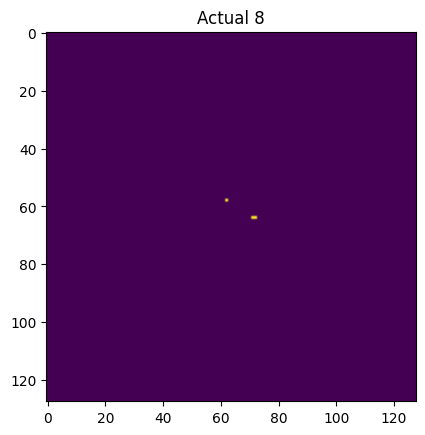

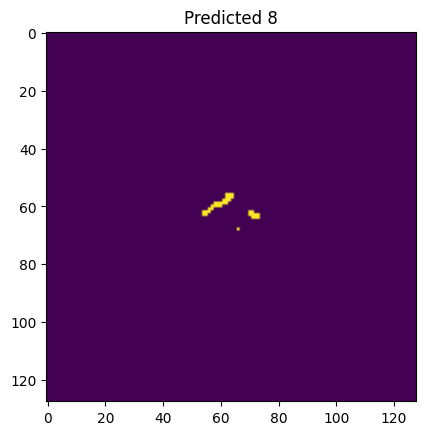

In [19]:

for i in range(y_batch_np.shape[0]):
    plt.figure()
    plt.title(f"Actual {i + 1}")
    split_val = 0.15
    val = y_batch_np[i, 0]
    plt.imshow(np.piecewise(val, [val < split_val, val >= split_val], [0, 1]))

    plt.figure()
    plt.title(f"Predicted {i + 1}")
    split_val = 0.5
    val = y_pred_np[i, 0]
    plt.imshow(np.piecewise(val, [val < split_val, val >= split_val], [0, 1]))
    #plt.imshow(val)

In [20]:
for batch_index, batch in enumerate(val_loader):
    if batch_index == 2:
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        y_pred = model(x_batch)
        print("found")
        break

print(torch.max(y_batch), torch.max(y_pred), torch.min(y_batch), torch.min(y_pred))

y_batch_np = y_batch.cpu().detach().numpy()
y_pred_np = y_pred.cpu().detach().numpy()


found
tensor(0.9098, device='cuda:0') tensor(0.8622, device='cuda:0', grad_fn=<MaxBackward1>) tensor(0., device='cuda:0') tensor(2.6424e-05, device='cuda:0', grad_fn=<MinBackward1>)


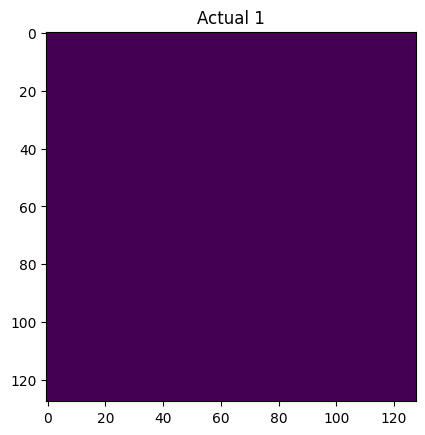

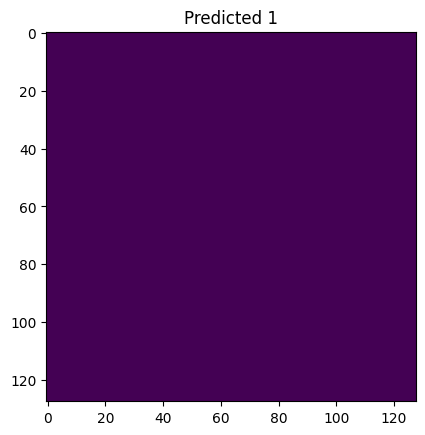

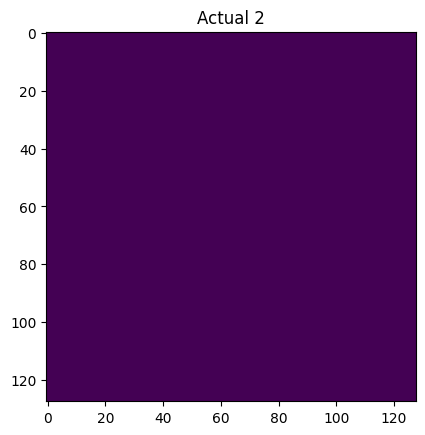

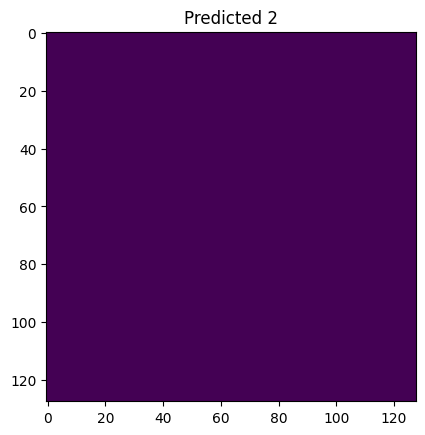

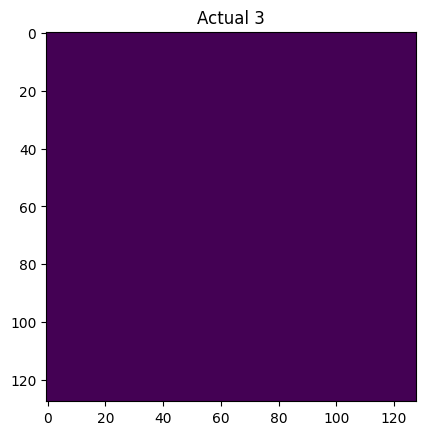

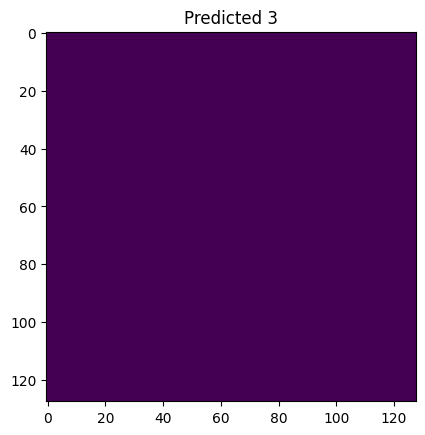

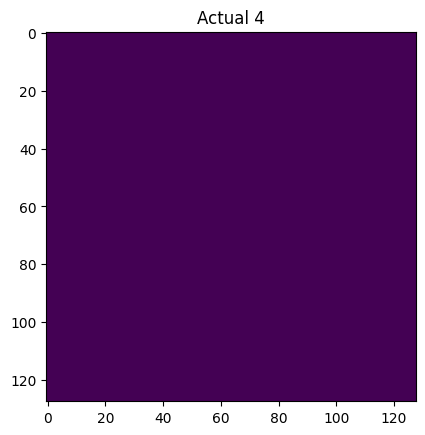

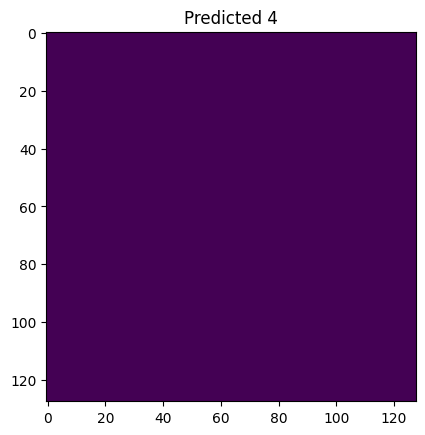

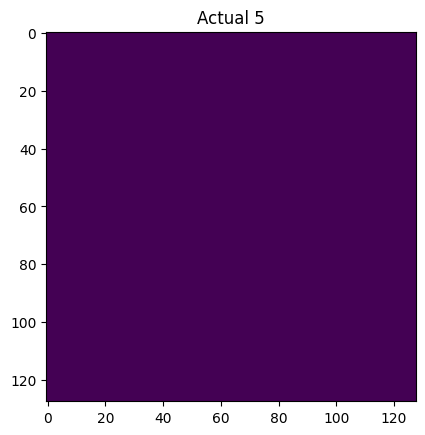

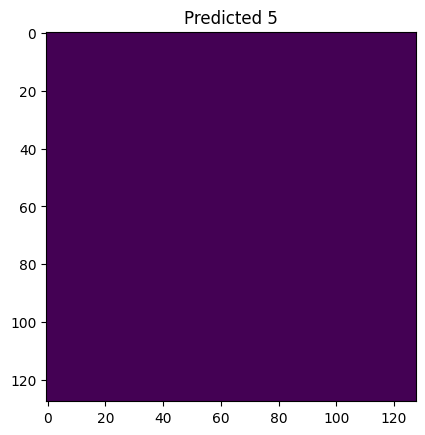

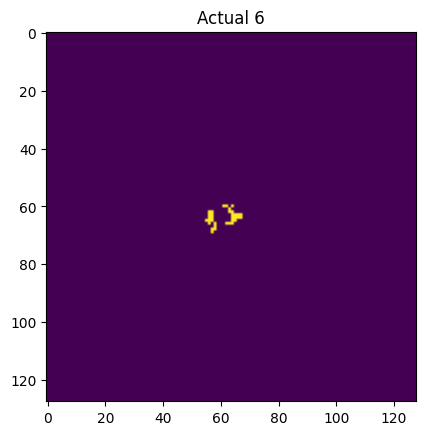

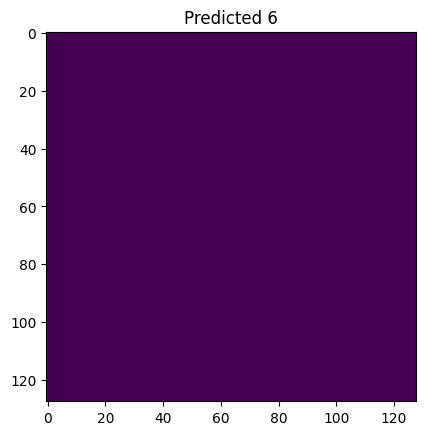

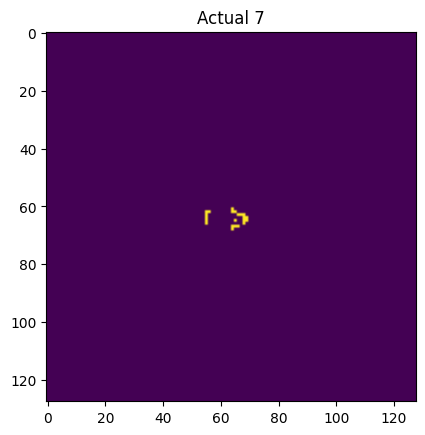

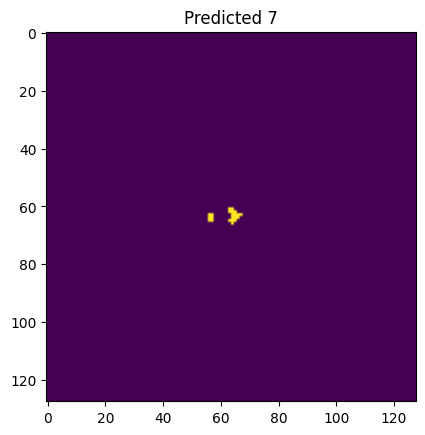

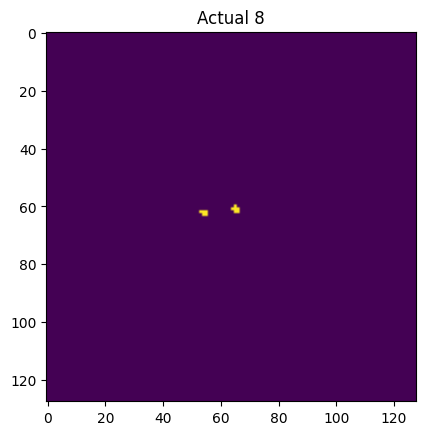

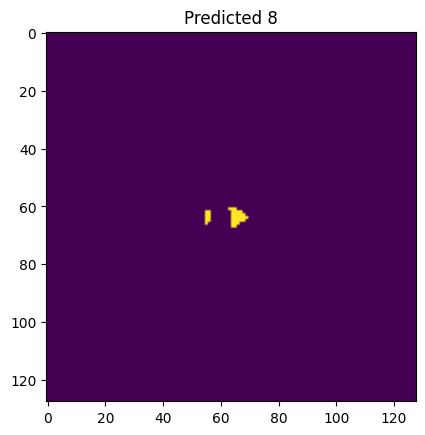

In [21]:
for i in range(y_batch_np.shape[0]):
    plt.figure()
    plt.title(f"Actual {i + 1}")
    split_val = 0.15
    val = y_batch_np[i, 0]
    plt.imshow(np.piecewise(val, [val < split_val, val >= split_val], [0, 1]))
    #plt.imshow(y_batch_np[i, 0])

    plt.figure()
    plt.title(f"Predicted {i + 1}")
    split_val = 0.5
    val = y_pred_np[i, 0]
    plt.imshow(np.piecewise(val, [val < split_val, val >= split_val], [0, 1]))
    #plt.imshow(y_pred_np[i, 0])